In [ ]:
import pandas as pd

# Upload csv file in folder named content in Google Colab
df = pd.read_csv("Personal_Finance_Dataset.csv")
df.head()

,Date,Transaction Description,Category,Amount,Type
0,2020-01-02,Score each.,Food & Drink,1485.69,Expense
1,2020-01-02,Quality throughout.,Utilities,1475.58,Expense
2,2020-01-04,Instead ahead despite measure ago.,Rent,1185.08,Expense
3,2020-01-05,Information last everything thank serve.,Investment,2291.00,Income
4,2020-01-13,Future choice whatever from.,Food & Drink,1126.88,Expense


In [ ]:
df_expense = df[df['Type'] == 'Expense']
df_expense['Date'] = pd.to_datetime(df_expense['Date'])
monthly_expense = (
    df_expense
    .groupby(pd.Grouper(key='Date', freq='ME'))['Amount']
    .sum()
    .reset_index()
)

monthly_expense.columns = ['date', 'expense']
monthly_expense.head()

/tmp/ipython-input-863383041.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_expense['Date'] = pd.to_datetime(df_expense['Date'])


,date,expense
0,2020-01-31,17138.25
1,2020-02-29,17108.41
2,2020-03-31,13581.81
3,2020-04-30,16233.05
4,2020-05-31,16846.13


In [ ]:
category_monthly = (
    df_expense
    .groupby([
        pd.Grouper(key='Date', freq='ME'),
        'Category'
    ])['Amount']
    .sum()
    .reset_index()
)

category_monthly.columns = ['date', 'category', 'expense']
category_monthly.head()

,date,category,expense
0,2020-01-31,Entertainment,1914.85
1,2020-01-31,Food & Drink,5458.51
2,2020-01-31,Health & Fitness,2370.34
3,2020-01-31,Rent,3663.22
4,2020-01-31,Salary,1077.09


In [ ]:
monthly_expense.isnull().sum()
monthly_expense = monthly_expense.dropna()

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(monthly_expense[['expense']])

In [ ]:
from prophet import Prophet

prophet_df = monthly_expense.rename(
    columns={'date':'ds', 'expense':'y'}
)

model = Prophet()
model.fit(prophet_df)

future = model.make_future_dataframe(periods=6, freq='ME')
forecast = model.predict(future)

# Below are just optional codes to verify that our code works correctly
# First code shows a table of yhat values for each month
forecast[['ds', 'yhat']].tail()
# 2nd code plots the graph of the time series forecast
model.plot(forecast)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat
61,2025-02-28,20402.308343
62,2025-03-31,20488.912059
63,2025-04-30,19098.462789
64,2025-05-31,21342.361479
65,2025-06-30,22675.037184


/tmp/ipython-input-863197529.py:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby(pd.Grouper(key='Date', freq='M'))['Amount']


Epoch 500, Loss: 0.001980
Epoch 1000, Loss: 0.000023
Epoch 1500, Loss: 0.000002
Epoch 2000, Loss: 0.000243
Epoch 2500, Loss: 0.000028
Epoch 3000, Loss: 0.000000
Epoch 3500, Loss: 0.000002
Epoch 4000, Loss: 0.000004
Epoch 4500, Loss: 0.000000
Epoch 5000, Loss: 0.000000
ANN -> MAE: 6785.36, MSE: 68996749.30, MAPE: 33.32%


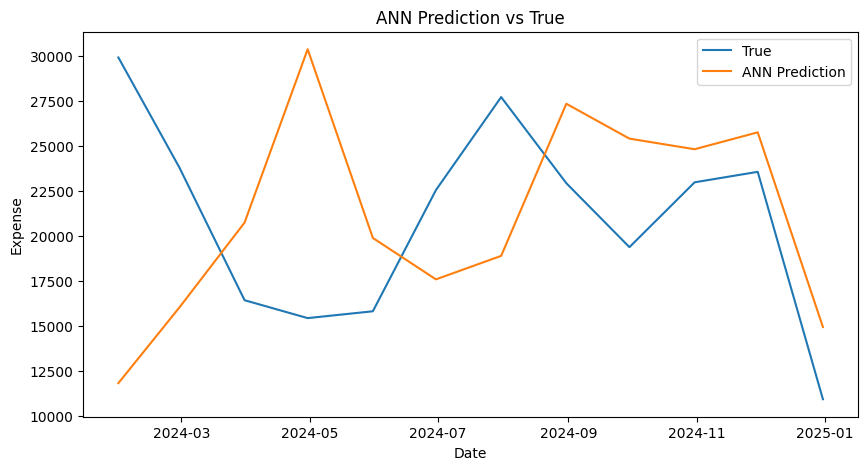

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


Prophet -> MAE: 4677.34, MSE: 27657233.36, MAPE: 25.99%
Average ANN+Prophet -> MAE: 5224.77, MSE: 39252894.19, MAPE: 27.34%


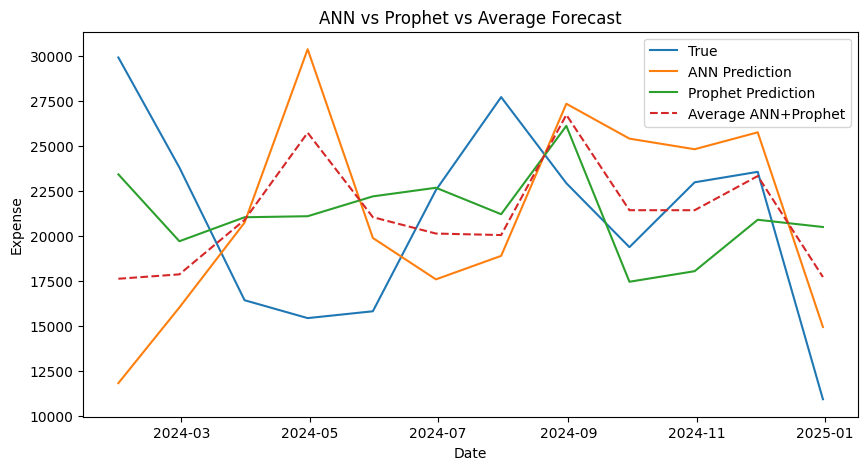

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from prophet import Prophet

# --------------------------
# Load & preprocess data
# --------------------------
df = pd.read_csv("Personal_Finance_Dataset.csv")
df['Date'] = pd.to_datetime(df['Date'])
df_expense = df[df['Type'] == 'Expense']

monthly_expense = (
    df_expense
    .groupby(pd.Grouper(key='Date', freq='M'))['Amount']
    .sum()
    .reset_index()
)
monthly_expense.columns = ['date', 'expense']
monthly_expense = monthly_expense.dropna()

scaler = StandardScaler()
monthly_expense['expense_scaled'] = scaler.fit_transform(monthly_expense[['expense']])

# --------------------------
# Dataset
# --------------------------
class ExpenseDataset(Dataset):
    def __init__(self, data, seq_len=6):
        self.data = data.values
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len].reshape(-1)  # (seq_len,)
        y = self.data[idx+self.seq_len]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Split train/test
train_size = int(len(monthly_expense) * 0.8)
train_data = monthly_expense['expense_scaled'][:train_size]
test_data = monthly_expense['expense_scaled'][train_size-6:]  # include last seq_len for continuity

train_dataset = ExpenseDataset(train_data, seq_len=6)
test_dataset = ExpenseDataset(test_data, seq_len=6)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# --------------------------
# ANN Model
# --------------------------
class ANN(nn.Module):
    def __init__(self, input_size=6, hidden_size=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
    def forward(self, x):
        return self.net(x)

model = ANN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# --------------------------
# Training
# --------------------------
epochs = 5000
for epoch in range(epochs):
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 500 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")

# --------------------------
# Testing
# --------------------------
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        output = model(x_batch)
        y_true.append(y_batch.item())
        y_pred.append(output.item())

# Inverse scale
y_true_inv = scaler.inverse_transform([[v] for v in y_true])
y_pred_inv = scaler.inverse_transform([[v] for v in y_pred])

y_true_inv = [v[0] for v in y_true_inv]
y_pred_inv = [v[0] for v in y_pred_inv]

# Metrics
mae = mean_absolute_error(y_true_inv, y_pred_inv)
mse = mean_squared_error(y_true_inv, y_pred_inv)
mape = (abs((pd.Series(y_true_inv) - pd.Series(y_pred_inv)) / pd.Series(y_true_inv)).mean()) * 100
print(f"ANN -> MAE: {mae:.2f}, MSE: {mse:.2f}, MAPE: {mape:.2f}%")

# --------------------------
# Plot
# --------------------------
plt.figure(figsize=(10,5))
plt.plot(monthly_expense['date'][train_size:], y_true_inv, label='True')
plt.plot(monthly_expense['date'][train_size:], y_pred_inv, label='ANN Prediction')
plt.xlabel('Date')
plt.ylabel('Expense')
plt.title('ANN Prediction vs True')
plt.legend()
plt.show()

# --------------------------
# Prophet Forecast
# --------------------------
prophet_df = monthly_expense[['date', 'expense']].rename(columns={'date':'ds','expense':'y'})
prophet_model = Prophet()
prophet_model.fit(prophet_df[:train_size])

future = prophet_model.make_future_dataframe(periods=len(y_true_inv), freq='M')
forecast = prophet_model.predict(future)

forecast_values = forecast['yhat'][-len(y_true_inv):].values
mae_p = mean_absolute_error(y_true_inv, forecast_values)
mse_p = mean_squared_error(y_true_inv, forecast_values)
mape_p = (abs((pd.Series(y_true_inv) - pd.Series(forecast_values)) / pd.Series(y_true_inv)).mean()) * 100
print(f"Prophet -> MAE: {mae_p:.2f}, MSE: {mse_p:.2f}, MAPE: {mape_p:.2f}%")


# --------------------------
# Average Prediction
# --------------------------
avg_pred = [(ann + prophet) / 2 for ann, prophet in zip(y_pred_inv, forecast_values)]

# Metrics for average
mae_avg = mean_absolute_error(y_true_inv, avg_pred)
mse_avg = mean_squared_error(y_true_inv, avg_pred)
mape_avg = (abs((pd.Series(y_true_inv) - pd.Series(avg_pred)) / pd.Series(y_true_inv)).mean()) * 100
print(f"Average ANN+Prophet -> MAE: {mae_avg:.2f}, MSE: {mse_avg:.2f}, MAPE: {mape_avg:.2f}%")

# Plot
plt.figure(figsize=(10,5))
plt.plot(monthly_expense['date'][train_size:], y_true_inv, label='True')
plt.plot(monthly_expense['date'][train_size:], y_pred_inv, label='ANN Prediction')
plt.plot(monthly_expense['date'][train_size:], forecast_values, label='Prophet Prediction')
plt.plot(monthly_expense['date'][train_size:], avg_pred, label='Average ANN+Prophet', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Expense')
plt.title('ANN vs Prophet vs Average Forecast')
plt.legend()
plt.show()
